In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install wordninja
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 541 kB 34.3 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=5521ec60a52020ad4833bca4ccc888d27dda04086382eeb84732ecadab2f0091
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 38.7 MB/s 


In [5]:
import re
import random
import math
import nltk
nltk.download('stopwords')
from tqdm.notebook import tqdm
from collections import Counter


from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt 

import wordninja
from spellchecker import SpellChecker
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preprocessing

In [6]:
data = pd.read_csv("/content/drive/MyDrive/datasets/tweets.csv")

# data contains one non-string entry for 'text'
str_mask = [isinstance(x, str) for x in data.text]
data = data[str_mask]

In [7]:
# standard tweet preprocessing 

data.text =data.text.str.lower()
#Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))
#remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))
# Remove all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))
#remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
# Convert string to a list of words
data['words'] = data.text.apply(lambda x:re.findall(r'\w+', x ))

In [8]:
# Helper functions 
def get_sign(x, p, n):
    if x > p:
        return 1
    if x < n:
        return -1 
    return 0

def flatten_list(l):
    return [x for y in l for x in y]

In [10]:
nltk.download('vader_lexicon')
sia = SIA()

sentiments = [sia.polarity_scores(x)['compound'] for x in tqdm(data['text'])]
classes = [get_sign(s, 0.35, -0.05) for s in sentiments]
data['classes'] = classes

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


  0%|          | 0/82308 [00:00<?, ?it/s]

In [11]:
def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

In [12]:
# Create one document each for all words in the negative, neutral and  positive classes respectively
neg_doc = flatten_list(data[data['classes'] == -1]['words'])
neg_doc = [x for x in neg_doc if is_acceptable(x)]

pos_doc = flatten_list(data[data['classes'] == +1]['words'])
pos_doc = [x for x in pos_doc if is_acceptable(x)]

neu_doc = flatten_list(data[data['classes'] == 0]['words'])
neu_doc = [x for x in neu_doc if is_acceptable(x)]

In [13]:
# color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

In [14]:
# reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Tweets")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

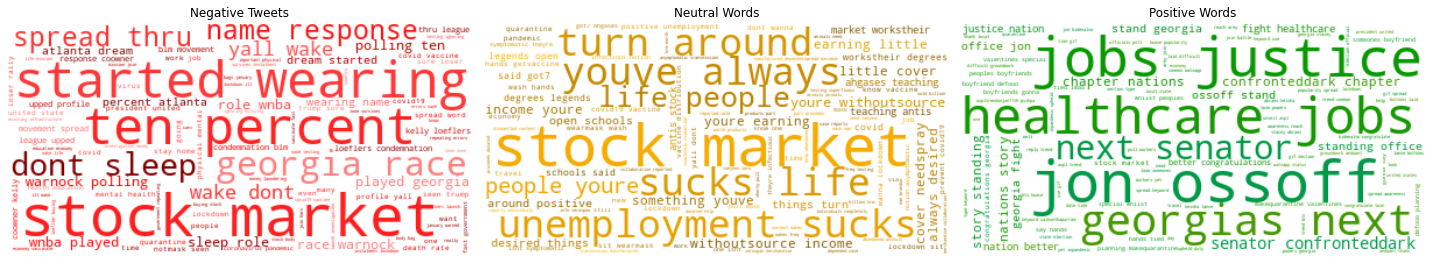

In [15]:
# Naive word clouds 
generate_word_clouds(neg_doc, neu_doc, pos_doc)